In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
run_simulation = True   # set to False to skip simulation and just load CSV
output_csv = "sim_results.csv"

In [2]:
if run_simulation:
    rng = np.random.default_rng(42)

    domains = ["Finance", "Genetics"]
    modalities = ["Text", "Voice"]
    styles = ["Brief", "Detailed", "Analogy"]
    n_features = 8         # features per scenario
    n_per_cell = 30        # samples per (domain × modality × style)

    # Hyperparameters (tunable)
    alpha = {"Text": 0.8, "Voice": 1.0}    # duration weight
    beta = {"Text": 0.9, "Voice": 1.1}     # complexity weight
    style_len = {"Brief": 0.7, "Detailed": 1.2, "Analogy": 1.0}
    wpm_text, wpm_voice = 220.0, 160.0
    gamma_entropy = {"Text": 0.65, "Voice": 0.85}
    gamma_dur = {"Text": 0.40, "Voice": 0.55}
    trust_bias = {"Text": 0.00, "Voice": 0.08}
    k_trust, b_trust = 3.0, 0.5

    def shannon_entropy(p):
        p = np.clip(p, 1e-12, 1.0)
        return -np.sum(p * np.log2(p))

    rows = []

    for domain in domains:
        for modality in modalities:
            for style in styles:
                for _ in range(n_per_cell):
                    # --- Generate synthetic SHAP-like attributions ---
                    A = rng.normal(0, 1, size=n_features)
                    mag = np.abs(A)
                    p = mag / mag.sum()
                    H_A = shannon_entropy(p)

                    # --- Compute message entropy & duration proxies ---
                    H_msg = H_A * style_len[style]
                    words = 60 + 40 * H_msg * n_features * style_len[style]
                    duration = (words / (wpm_text if modality == "Text" else wpm_voice)) * 60.0

                    # --- Information retention ---
                    loss = (gamma_entropy[modality] * H_msg + gamma_dur[modality] * (duration / 120.0))
                    I_M = np.exp(-loss)
                    I_M = float(np.clip(I_M, 0.0, 1.0))

                    # --- Cognitive load ---
                    L = alpha[modality] * duration + beta[modality] * H_msg

                    # --- Comprehension Efficiency ---
                    CE = I_M / (L + 1e-9)

                    # --- Trust calibration ---
                    T = 1.0 / (1.0 + np.exp(-k_trust * (I_M - b_trust))) + trust_bias[modality]
                    T = float(np.clip(T, 0.0, 1.0))
                    Q = I_M
                    TCE = abs(T - Q)

                    rows.append({
                        "domain": domain,
                        "modality": modality,
                        "style": style,
                        "H_A": H_A,
                        "H_msg": H_msg,
                        "words": words,
                        "duration_s": duration,
                        "I_M": I_M,
                        "L": L,
                        "CE": CE,
                        "T": T,
                        "Q": Q,
                        "TCE": TCE
                    })

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"✅ Simulation complete — saved {len(df)} rows to {output_csv}")

✅ Simulation complete — saved 360 rows to sim_results.csv


In [3]:
df = pd.read_csv(output_csv)
print(f"Loaded {len(df)} samples from {output_csv}")

# Aggregate by modality × style
agg = df.groupby(["modality", "style"]).agg(
    CE_mean=("CE", "mean"),
    TCE_mean=("TCE", "mean"),
    duration_s_mean=("duration_s", "mean"),
    I_M_mean=("I_M", "mean")
).reset_index()

Loaded 360 samples from sim_results.csv


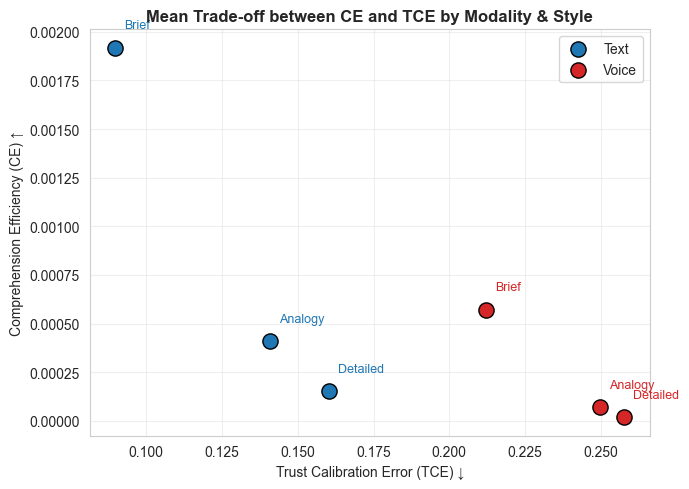

In [4]:
plt.figure(figsize=(7,5))
for modality, color in zip(["Text","Voice"], ["#1f77b4","#d62728"]):
    sub = agg[agg["modality"] == modality]
    plt.scatter(sub["TCE_mean"], sub["CE_mean"], s=120, color=color, label=modality, edgecolor='black', zorder=3)
    for _, r in sub.iterrows():
        plt.text(r["TCE_mean"] + 0.003, r["CE_mean"] + 0.0001, r["style"], fontsize=9, color=color)

plt.xlabel("Trust Calibration Error (TCE) ↓")
plt.ylabel("Comprehension Efficiency (CE) ↑")
plt.title("Mean Trade-off between CE and TCE by Modality & Style", fontsize=12, weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("fig_ce_tce_means.png", dpi=300)
plt.show()

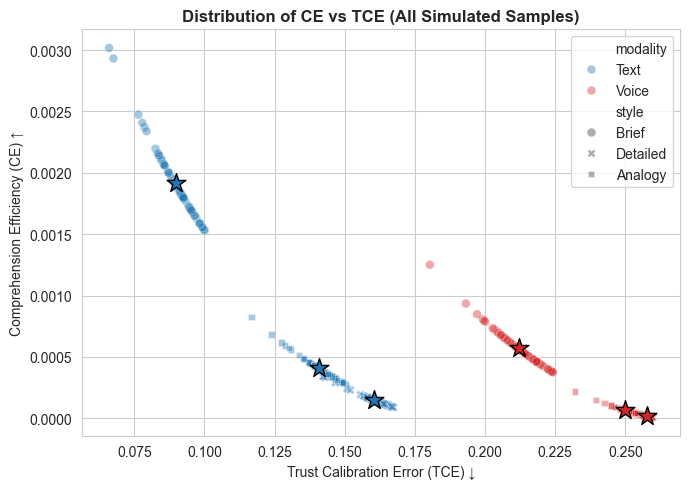

In [5]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df, x="TCE", y="CE", hue="modality", style="style",
    palette={"Text":"#1f77b4","Voice":"#d62728"},
    alpha=0.4, s=40
)
for modality, color in zip(["Text","Voice"], ["#1f77b4","#d62728"]):
    sub = agg[agg["modality"] == modality]
    plt.scatter(sub["TCE_mean"], sub["CE_mean"], s=200, color=color, marker='*', edgecolor='black', zorder=5)

plt.xlabel("Trust Calibration Error (TCE) ↓")
plt.ylabel("Comprehension Efficiency (CE) ↑")
plt.title("Distribution of CE vs TCE (All Simulated Samples)", fontsize=12, weight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("fig_ce_tce_scatter.png", dpi=300)
plt.show()

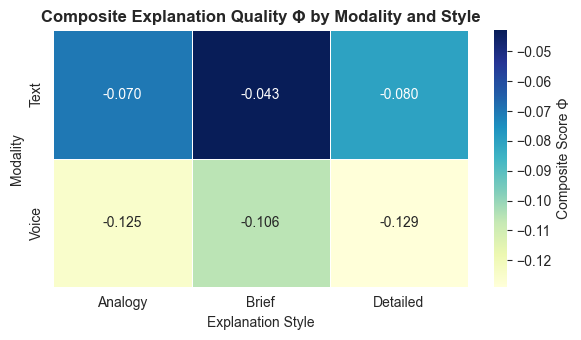

✅ All figures saved: fig_ce_tce_means.png, fig_ce_tce_scatter.png, fig_phi_heatmap.png


In [6]:
lambda1, lambda2 = 1.0, 0.5
agg["Phi"] = lambda1 * agg["CE_mean"] - lambda2 * agg["TCE_mean"]
heatmap_data = agg.pivot(index="modality", columns="style", values="Phi")

plt.figure(figsize=(6,3.5))
ax = sns.heatmap(
    heatmap_data, annot=True, cmap="YlGnBu", fmt=".3f",
    linewidths=0.5, cbar_kws={'label': 'Composite Score Φ'},
    annot_kws={"size":10}
)
plt.title("Composite Explanation Quality Φ by Modality and Style", fontsize=12, weight='bold')
plt.xlabel("Explanation Style")
plt.ylabel("Modality")
plt.tight_layout()
plt.savefig("fig_phi_heatmap.png", dpi=300)
plt.show()
print("✅ All figures saved: fig_ce_tce_means.png, fig_ce_tce_scatter.png, fig_phi_heatmap.png")

/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_71013/3082257441.py:18: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_71013/3082257441.py:19: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("fig_phi_sensitivity.png", dpi=300, bbox_inches="tight")
/Users/vkhawarey/Documents/git/moviecruncher/dataviz/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


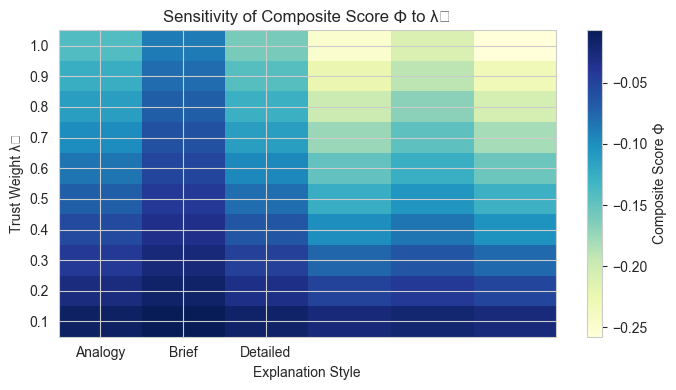

In [7]:
lambda2_values = np.linspace(0.1, 1.0, 10)
results = []

for lambda2 in lambda2_values:
    Phi_values = agg["CE_mean"] - lambda2 * agg["TCE_mean"]
    results.append(Phi_values.values)

results = np.array(results)

plt.figure(figsize=(7,4))
plt.imshow(results, cmap="YlGnBu", aspect="auto", origin="lower")
plt.colorbar(label="Composite Score Φ")
plt.xticks(range(len(agg["style"].unique())), agg["style"].unique())
plt.yticks(range(len(lambda2_values)), [f"{v:.1f}" for v in lambda2_values])
plt.xlabel("Explanation Style")
plt.ylabel("Trust Weight λ₂")
plt.title("Sensitivity of Composite Score Φ to λ₂")
plt.tight_layout()
plt.savefig("fig_phi_sensitivity.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_71013/4267238068.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Modality")


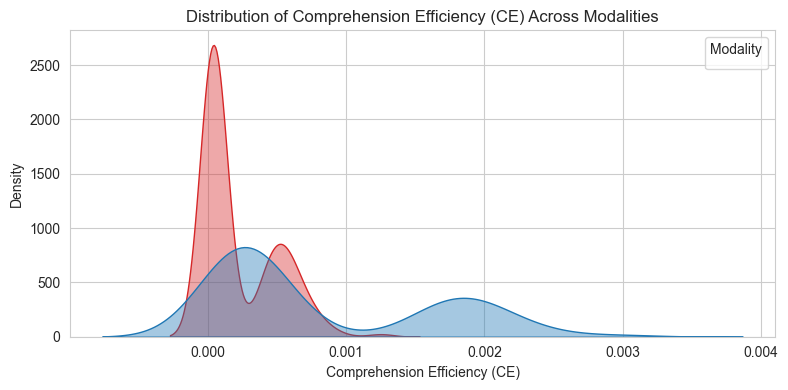

/var/folders/n0/l2z_5jzs5_ld852y4kztbyz40000gq/T/ipykernel_71013/4267238068.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Modality")


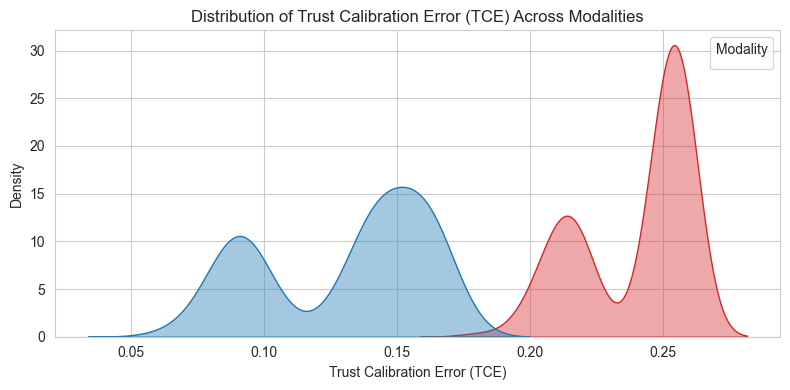

In [8]:
plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df, x="CE", hue="modality",
    fill=True, common_norm=False, alpha=0.4,
    palette={"Text": "#1f77b4", "Voice": "#d62728"}
)
plt.xlabel("Comprehension Efficiency (CE)")
plt.ylabel("Density")
plt.title("Distribution of Comprehension Efficiency (CE) Across Modalities")
plt.legend(title="Modality")
plt.tight_layout()
plt.savefig("fig_ce_kde.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
sns.kdeplot(
    data=df, x="TCE", hue="modality",
    fill=True, common_norm=False, alpha=0.4,
    palette={"Text": "#1f77b4", "Voice": "#d62728"}
)
plt.xlabel("Trust Calibration Error (TCE)")
plt.ylabel("Density")
plt.title("Distribution of Trust Calibration Error (TCE) Across Modalities")
plt.legend(title="Modality")
plt.tight_layout()
plt.savefig("fig_tce_kde.png", dpi=300, bbox_inches="tight")
plt.show()